In [77]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 17.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
matchid = 2
team = 'Huskies'

In [153]:
def plot_network(team, matchid, ax=None, savefig=False):
    df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
    df = df[df['MatchID'] == matchid]
    df = df[df['TeamID'] == team]

    # calculate average position of each player
    uniq_player = np.unique(
        np.union1d(df['OriginPlayerID'], df['DestinationPlayerID']))
    x_mean = [
        np.mean(
            list(df[df['OriginPlayerID'] == name]['EventOrigin_x']) +
            list(df[df['DestinationPlayerID'] == name]['EventDestination_x']))
        for name in uniq_player
    ]
    y_mean = [
        np.mean(
            list(df[df['OriginPlayerID'] == name]['EventOrigin_y']) +
            list(df[df['DestinationPlayerID'] == name]['EventDestination_y']))
        for name in uniq_player
    ]

    pos = {
        name: np.array([x_mean[i], y_mean[i]])
        for i, name in enumerate(uniq_player)
    }

    # Build Directional graph
    G = nx.from_pandas_edgelist(df, source='OriginPlayerID', 
                                target='DestinationPlayerID', 
                                edge_attr=True, 
                                create_using=nx.DiGraph())

    # Calculate degree centrality
    deg_centrality = nx.algorithms.centrality.degree_centrality(G)
    deg_centrality = np.array([deg_centrality[node] for node in list(G.nodes())])

    # Calculate betweenness centrality
    between_centrality = nx.algorithms.centrality.betweenness_centrality(G)
    between_centrality = np.array([between_centrality[node] for node in list(G.nodes())])

    # Calculate eigenvector centrality
    eigen_centrality = nx.algorithms.centrality.eigenvector_centrality(G)
    eigen_centrality = np.array([eigen_centrality[node] for node in list(G.nodes())])

    # Calculate total (in + out) passes through a node
    team_passes = utils.match_i_passing_table('./2020_Problem_D_DATA/passingevents.csv', 
                                              team_id=team, match_i=matchid)
    node_passes = np.array([np.sum(team_passes[node]) for node in list(G.nodes())])

    # Calculate geometrical distance between nodes (as a weight)
    geometrical_dist = {}
    from scipy.spatial import distance
    for edge in G.edges:
        geometrical_dist[edge] = distance.euclidean(pos[edge[0]], pos[edge[1]])


    # Calculate passes from A to B (as a weight)
    H = nx.from_pandas_edgelist(df[['OriginPlayerID', 'DestinationPlayerID']], 
                                source='OriginPlayerID', 
                                target='DestinationPlayerID', edge_attr=True, 
                                create_using=nx.MultiDiGraph()) ### Multi-Directional graph
    unidirection_pass = {}
    for edge in H.edges:
        unidirection_pass[(edge[0], edge[1])] = H.number_of_edges(edge[0], edge[1])

    # Plot the network
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        ax = ax
        
    node_size = np.exp(eigen_centrality / np.sort(eigen_centrality)[1])
    node_size = node_size / np.nanmean(node_size) * 1500

    node_color = np.log10(between_centrality)
    
    nx.draw_networkx(G, pos, ax=ax, 
                     node_size=node_size, 
                     node_color=node_color, 
                     edgelist=list(unidirection_pass.keys()), 
                     width=np.array(list(unidirection_pass.values())) / 1.5,
                     edge_color='gray', cmap='RdBu_r', 
                     vmin=node_color[~np.isinf(node_color)][-1], 
                     vmax=max(node_color), arrowsize=15, arrowstyle='->')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=node_color[~np.isinf(node_color)][-1], 
                                                                 vmax=max(node_color)))
    cbar = plt.colorbar(sm, ax=ax, extend='both')
    cbar.set_label('log( Betweenness Centrality )')

    plt.tick_params(direction='in')
    if savefig:
        plt.savefig('./{0}_match{1}.png'.format(team, matchid), bbox_inches='tight')
        
    return ax

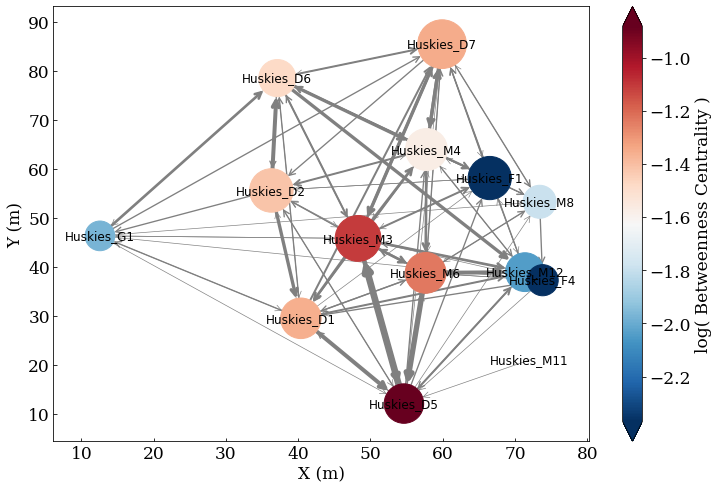

In [154]:
_ = plot_network('Huskies', matchid=20)

In [160]:
df_matches = pd.read_csv('./2020_Problem_D_DATA/matches.csv')
for ind, game in df_matches.iterrows():
    matchid = game['MatchID']
    oppo = game['OpponentID']
    
    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    ax1 = plot_network('Huskies', matchid=matchid, ax=ax1)
    ax1.set_xlabel('')
    ax2 = plot_network(oppo, matchid=matchid, ax=ax2)
    plt.suptitle(game['Outcome'], x=0.44, y=0.92)
    plt.tick_params(direction='in')
    plt.subplots_adjust(hspace=0)
    plt.savefig('./Figures/match{0}_{1}.png'.format(matchid, game['Outcome']), bbox_inches='tight')
    plt.close()

In [91]:
# get attributes of an edge
G.get_edge_data('Huskies_D3', 'Huskies_D2')

{'MatchID': 1,
 'TeamID': 'Huskies',
 'OriginPlayerID': 'Huskies_D3',
 'DestinationPlayerID': 'Huskies_D2',
 'MatchPeriod': '1H',
 'EventTime': 766.375013,
 'EventSubType': 'Simple pass',
 'EventOrigin_x': 26,
 'EventOrigin_y': 15,
 'EventDestination_x': 28.0,
 'EventDestination_y': 46.0}

## Calculate motifs in the network

In [14]:
## We define each S* motif as a directed graph in networkx
## up=1, down=3, right=2
motifs = {
    'S1': nx.DiGraph([(2,1),(2,3)]),
    'S2': nx.DiGraph([(3,2),(2,1)]),
    'S3': nx.DiGraph([(3,2),(2,3),(2,1)]),
    'S4': nx.DiGraph([(3,1),(2,1)]),
    'S5': nx.DiGraph([(3,1),(2,1),(2,3)]),
    'S6': nx.DiGraph([(3,1),(2,1),(2,3),(3,2)]),
    'S7': nx.DiGraph([(3,2),(2,3),(1,2)]),
    'S8': nx.DiGraph([(3,2),(2,3),(2,1),(1,2)]),
    'S9': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S10': nx.DiGraph([(1,2),(2,3),(3,1),(2,1)]),
    'S11': nx.DiGraph([(1,2),(2,1),(3,2),(3,1)]),
    'S12': nx.DiGraph([(1,2),(2,1),(3,2),(2,3),(3,1)]),
    'S13': nx.DiGraph([(1,2),(2,1),(2,3),(3,2),(3,1),(1,3)])
    }

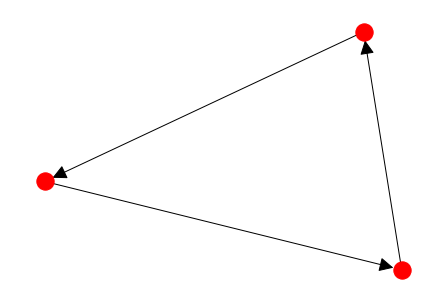

In [18]:
nx.draw(motifs['S9'], arrowsize=30)

In [16]:
from utils import mcounter
mcounter(G, motifs)

{'S1': 9,
 'S2': 18,
 'S3': 21,
 'S4': 11,
 'S5': 9,
 'S6': 10,
 'S7': 17,
 'S8': 13,
 'S9': 5,
 'S10': 14,
 'S11': 5,
 'S12': 34,
 'S13': 14}